In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from keras import metrics
from sklearn.preprocessing import MinMaxScaler


In [4]:
ts_df = pd.read_csv('../input/timeseries-btc/final_price_dataset.csv')
ts_df = ts_df.set_index('Date')
ts_df = ts_df.drop(['Unnamed: 0'],axis=1)


In [5]:
ts_df.head()

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti
Date,,,,,,,,,,
2018-01-01,0.043336,8.290000e+21,1.485130e+19,241601,13436.40113,78430,-2.93,62044.0,44,0.189724
2018-01-02,0.047594,8.290000e+21,1.644330e+19,340809,14732.45336,137730,9.74,77723.0,54,1.243548
2018-01-03,0.043609,8.290000e+21,1.497180e+19,395806,15068.48685,106540,2.73,79086.0,55,0.791414
2018-01-04,0.046728,8.290000e+21,1.613350e+19,424840,15150.04439,110970,0.15,74534.0,51,1.228296
2018-01-05,0.039635,8.290000e+21,1.372410e+19,342564,16929.99358,141960,11.69,76404.0,50,1.762493


<AxesSubplot:>

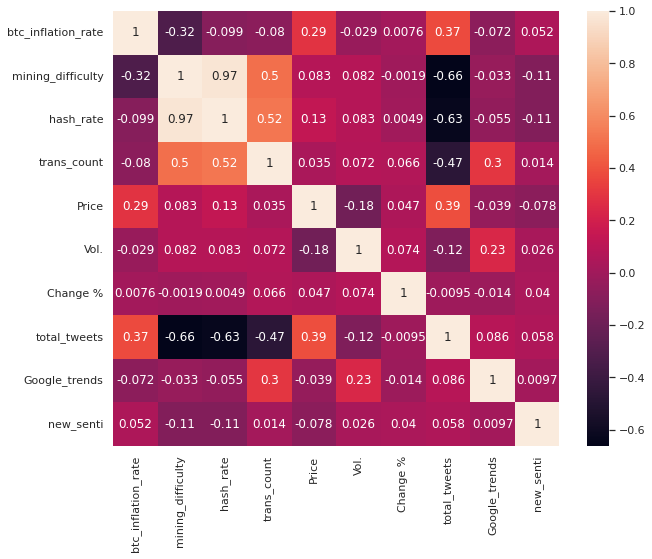

In [6]:
sns.set(rc = {'figure.figsize':(10,8)})

sns.heatmap(ts_df.corr(),annot=True)

In [7]:
ts_df.isnull().sum()

btc_inflation_rate    0
mining_difficulty     0
hash_rate             0
trans_count           0
Price                 0
Vol.                  0
Change %              0
total_tweets          0
Google_trends         0
new_senti             0
dtype: int64

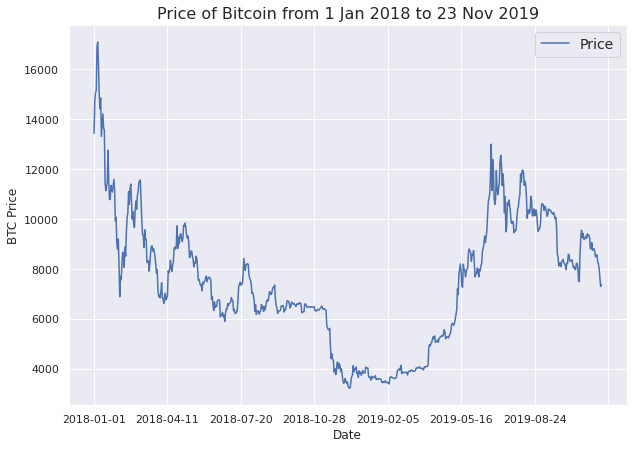

In [8]:
ts_df['Price'].plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Jan 2018 to 23 Nov 2019", fontsize=16)
plt.legend(fontsize=14);

In [9]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    sns.set_style(style='white')
    sns.lineplot(timesteps[start:end], values[start:end], label=label)
    plt.xlabel("Date")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    

In [10]:
# Function for MASE metric
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [11]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [12]:
#model checkpoint
def create_model_checkpoint(model_name, save_path='./model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

In [13]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) 

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

### Model_1: Dense Model ( horizon:1, window: 7 )

In [15]:
HORIZON=1
WINDOW_SIZE=7

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,0.736042,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,0.829572,0.736042,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,0.853822,0.829572,0.736042,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,0.859708,0.853822,0.829572,0.736042,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,0.988159,0.859708,0.853822,0.829572,0.736042,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,0.848753,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572


In [17]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(548, 548, 137, 137)

In [18]:
tf.random.set_seed(42)

model_1 = Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
],name='model_1_multivariate')

model_1.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())

2022-04-27 21:21:36.484008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 21:21:36.579649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 21:21:36.580462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 21:21:36.581642: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
history = model_1.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_1.name)],verbose=0)

2022-04-27 21:21:38.953619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-27 21:21:40.792641: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [20]:
model_1.summary()

Model: "model_1_multivariate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2176      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 27,009
Trainable params: 27,009
Non-trainable params: 0
_________________________________________________________________


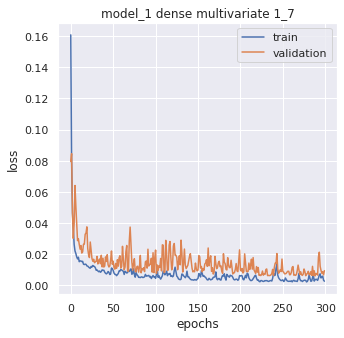

In [21]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_1 dense multivariate 1_7')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
model_1 = tf.keras.models.load_model("./model_experiments/model_1_multivariate")
model_1.evaluate(X_test, y_test)
model_1_preds = make_preds(model_1, X_test)
model_1_results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model_1_preds)
model_1_results

5/5 [==============================] - 0s 2ms/step - loss: 0.0061


{'mae': 0.0061353906,
 'mse': 6.7031164e-05,
 'rmse': 0.008187256,
 'mape': 1.3761792,
 'mase': 0.36843652}

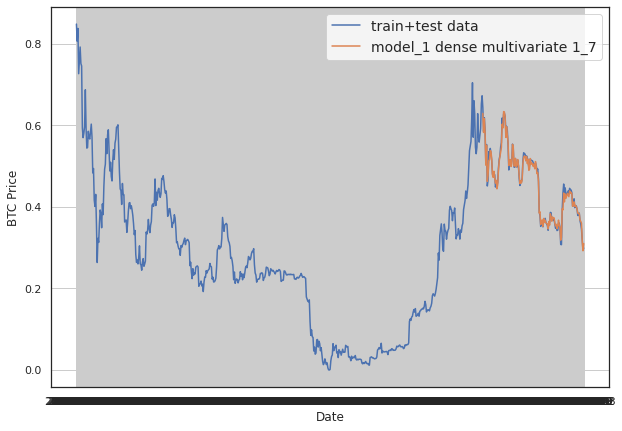

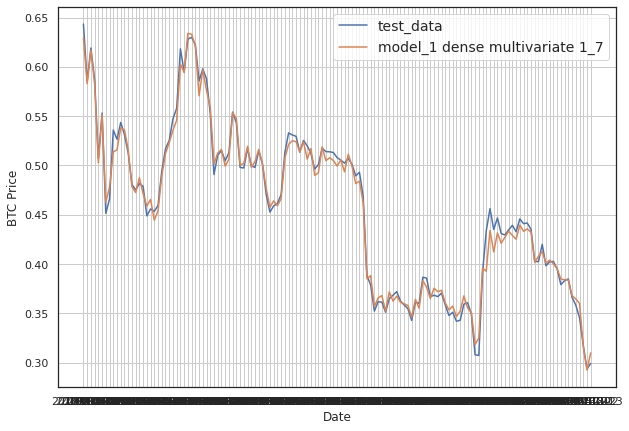

In [23]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X.index, values=y.values, label="train+test data")
plot_time_series(timesteps=X_test.index, values=model_1_preds, format="-", label="model_1 dense multivariate 1_7")

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test.index, values=y_test.values, label="test_data")
plot_time_series(timesteps=X_test.index, values=model_1_preds, format="-", label="model_1 dense multivariate 1_7")

### Model_2: Dense Model ( horizon:1, window: 30 )

In [24]:
HORIZON=1
WINDOW_SIZE=30

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(529, 529, 133, 133)

In [27]:
tf.random.set_seed(42)

model_2 = Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
],name='model_2_multivariate')

model_2.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())

In [28]:
history = model_2.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_2.name)],verbose=0)

In [29]:
model_2.summary()

Model: "model_2_multivariate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               5120      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 29,953
Trainable params: 29,953
Non-trainable params: 0
_________________________________________________________________


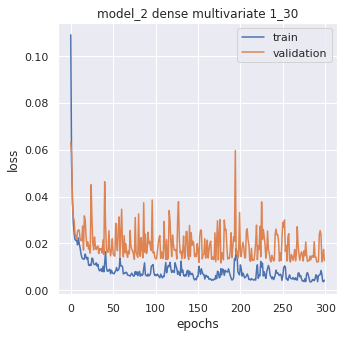

In [30]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_2 dense multivariate 1_30')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [31]:
model_2 = tf.keras.models.load_model("./model_experiments/model_2_multivariate")
model_2.evaluate(X_test, y_test)
model_2_preds = make_preds(model_2, X_test)
model_2_results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model_2_preds)
model_2_results

5/5 [==============================] - 0s 2ms/step - loss: 0.0116


{'mae': 0.011646935,
 'mse': 0.00025783706,
 'rmse': 0.016057305,
 'mape': 2.6320329,
 'mase': 0.7462701}

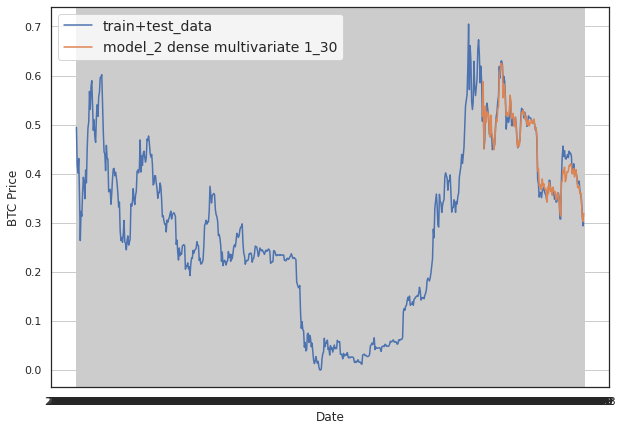

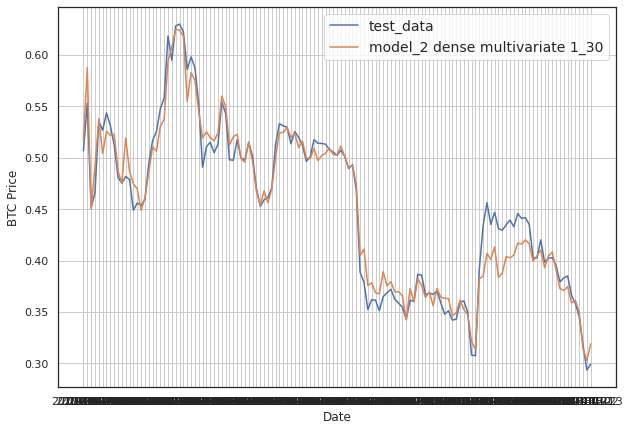

In [32]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X.index, values=y.values, label="train+test_data")
plot_time_series(timesteps=X_test.index, values=model_2_preds, format="-", label="model_2 dense multivariate 1_30")

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test.index, values=y_test.values, label="test_data")
plot_time_series(timesteps=X_test.index, values=model_2_preds, format="-", label="model_2 dense multivariate 1_30")

### Model_3: LSTM Model ( horizon:1, window: 7 )

In [33]:
HORIZON=1
WINDOW_SIZE=7

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,0.736042,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,0.829572,0.736042,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,0.853822,0.829572,0.736042,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,0.859708,0.853822,0.829572,0.736042,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,0.988159,0.859708,0.853822,0.829572,0.736042,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,0.848753,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572


In [35]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(548, 548, 137, 137)

In [36]:
X_train.shape

(548, 16)

In [37]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(16))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) 
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_3_LSTM")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [38]:
history = model_3.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_3.name)],verbose=0)

In [39]:
model_3.summary()

Model: "model_3_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 16)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 78,401
Trainable params: 78,401
Non-trainable params: 0
_________________________________________________________________


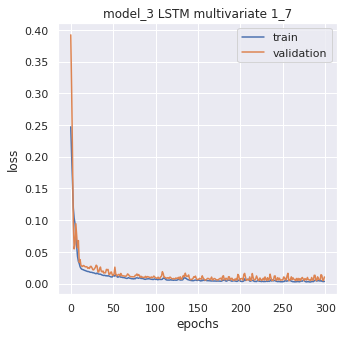

In [40]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_3 LSTM multivariate 1_7')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [41]:
model_3 = tf.keras.models.load_model("./model_experiments/model_3_LSTM")
model_3.evaluate(X_test, y_test)
model_3_preds = make_preds(model_3, X_test)
model_3_results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model_3_preds)
model_3_results

5/5 [==============================] - 0s 2ms/step - loss: 0.0046


{'mae': 0.0046042684,
 'mse': 4.0460924e-05,
 'rmse': 0.0063608903,
 'mape': 1.028772,
 'mase': 0.27649105}

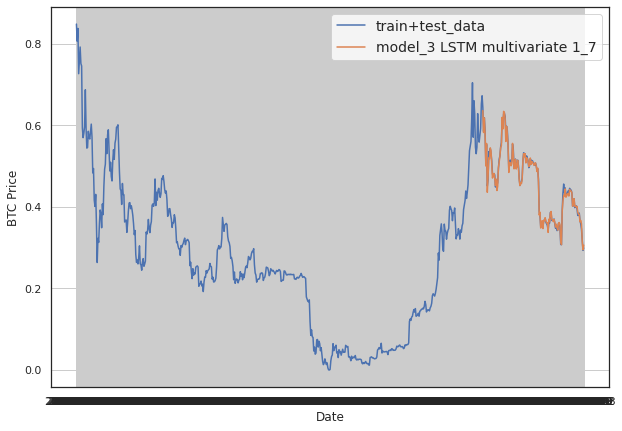

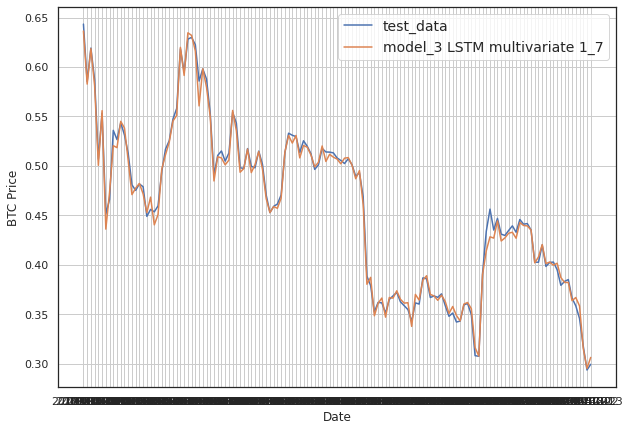

In [42]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X.index, values=y.values, label="train+test_data")
plot_time_series(timesteps=X_test.index, values=model_3_preds, format="-", label="model_3 LSTM multivariate 1_7")

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test.index, values=y_test.values, label="test_data")
plot_time_series(timesteps=X_test.index, values=model_3_preds, format="-", label="model_3 LSTM multivariate 1_7")

### Model_4: LSTM ( horizon:1, window: 30 )

In [43]:
HORIZON=1
WINDOW_SIZE=30

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(529, 529, 133, 133)

In [46]:
X_train.shape

(529, 39)

In [47]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(39))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) 
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_LSTM")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [48]:
history = model_4.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_4.name)],verbose=0)

In [49]:
model_4.summary()

Model: "model_4_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 39)]              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 39)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               86016     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 90,177
Trainable params: 90,177
Non-trainable params: 0
_________________________________________________________________


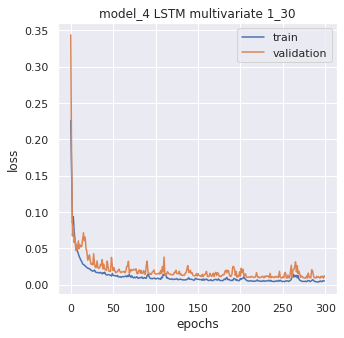

In [50]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_4 LSTM multivariate 1_30')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [51]:
model_4 = tf.keras.models.load_model("./model_experiments/model_4_LSTM")
model_4.evaluate(X_test, y_test)
model_4_preds = make_preds(model_4, X_test)
model_4_results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model_4_preds)
model_4_results

5/5 [==============================] - 0s 2ms/step - loss: 0.0090


{'mae': 0.008964072,
 'mse': 0.00014407955,
 'rmse': 0.012003314,
 'mape': 2.054918,
 'mase': 0.57436734}

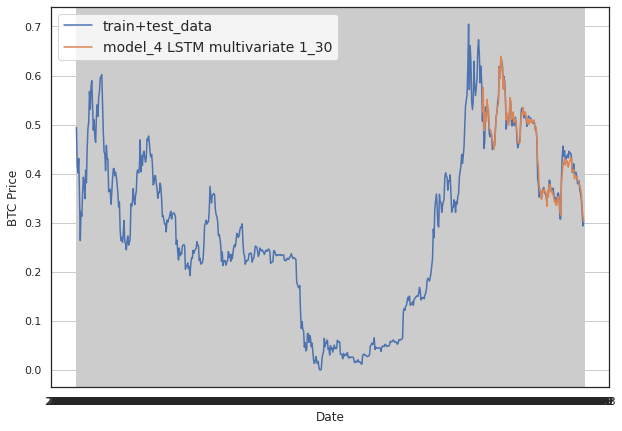

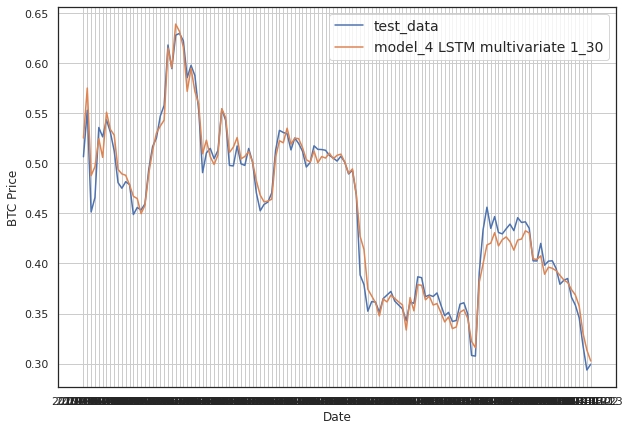

In [52]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X.index, values=y.values, label="train+test_data")
plot_time_series(timesteps=X_test.index, values=model_4_preds, format="-", label="model_4 LSTM multivariate 1_30")

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test.index, values=y_test.values, label="test_data")
plot_time_series(timesteps=X_test.index, values=model_4_preds, format="-", label="model_4 LSTM multivariate 1_30")

### Model_5 CNNLSTM ( horizon=1, window=7 )

In [53]:
HORIZON=1
WINDOW_SIZE=7

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,0.736042,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,0.829572,0.736042,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,0.853822,0.829572,0.736042,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,0.859708,0.853822,0.829572,0.736042,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,0.988159,0.859708,0.853822,0.829572,0.736042,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,0.848753,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572


In [55]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(548, 548, 137, 137)

In [56]:
tf.random.set_seed(42)


model_5 = Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",
                      activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
],name='CNNLSTM_model_5_multivariate')

model_5.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())



In [57]:
history = model_5.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_5.name)],verbose=0)

2022-04-27 21:28:26.456102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [58]:
model_5.summary()

Model: "CNNLSTM_model_5_multivariate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1, 16)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             5184      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dense_12 (Dense)             (None, 1, 30)             1950      
_________________________________________________________________
dense_13 (Dense)             (None, 1, 10)             310       
_________________________________________________________________
dense_14 (Dense)             (None, 1,

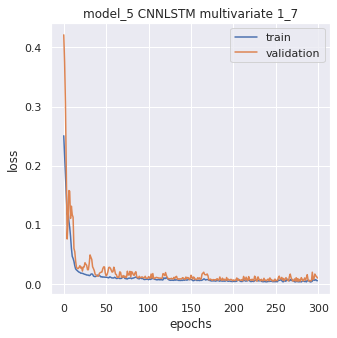

In [59]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_5 CNNLSTM multivariate 1_7')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [60]:
model_5 = tf.keras.models.load_model("./model_experiments/CNNLSTM_model_5_multivariate")
model_5.evaluate(X_test, y_test)
model_5_preds = make_preds(model_5, X_test)
model_5_results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model_5_preds)
model_5_results

5/5 [==============================] - 1s 11ms/step - loss: 0.0044


{'mae': 0.00444496,
 'mse': 3.4412424e-05,
 'rmse': 0.0058662104,
 'mape': 0.99845034,
 'mase': 0.2669244}

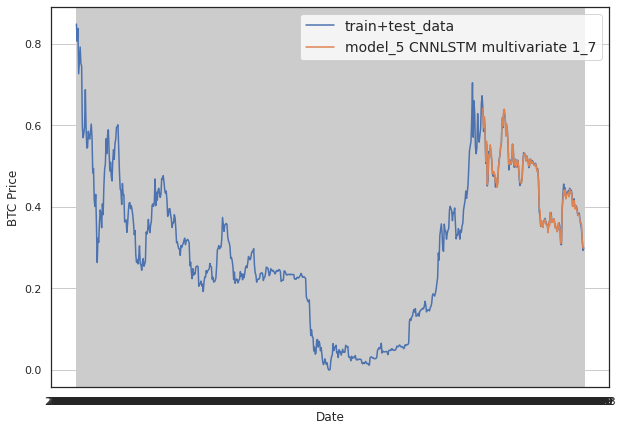

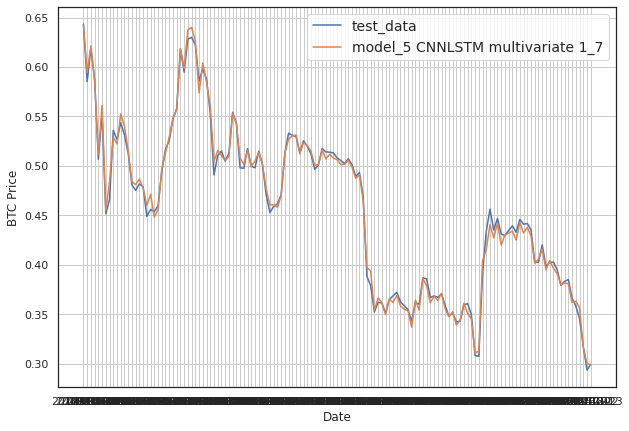

In [61]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X.index, values=y.values, label="train+test_data")
plot_time_series(timesteps=X_test.index, values=model_5_preds, format="-", label="model_5 CNNLSTM multivariate 1_7")

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test.index, values=y_test.values, label="test_data")
plot_time_series(timesteps=X_test.index, values=model_5_preds, format="-", label="model_5 CNNLSTM multivariate 1_7")

### Model_6: CNNLSTM (horizon:1, window:30)

In [62]:
HORIZON=1
WINDOW_SIZE=30

In [63]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(529, 529, 133, 133)

In [65]:
tf.random.set_seed(42)


model_6 = Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",
                      activation="relu"),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
],name='CNNLSTM_model_6_multivariate')

model_6.compile(loss='mae',optimizer=tf.keras.optimizers.Adam())


In [66]:
history = model_6.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_6.name)],verbose=0)

In [67]:
model_6.summary()

Model: "CNNLSTM_model_6_multivariate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 1, 39)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             12544     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dense_15 (Dense)             (None, 1, 30)             1950      
_________________________________________________________________
dense_16 (Dense)             (None, 1, 10)             310       
_________________________________________________________________
dense_17 (Dense)             (None, 1,

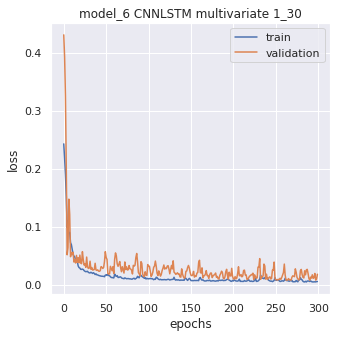

In [68]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_6 CNNLSTM multivariate 1_30')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [69]:
model_6 = tf.keras.models.load_model("./model_experiments/CNNLSTM_model_6_multivariate")
model_6.evaluate(X_test, y_test)
model_6_preds = make_preds(model_6, X_test)
model_6_results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model_6_preds)
model_6_results

5/5 [==============================] - 1s 4ms/step - loss: 0.0079


{'mae': 0.007944167,
 'mse': 0.00010507856,
 'rmse': 0.0102507835,
 'mape': 1.8091274,
 'mase': 0.5090175}

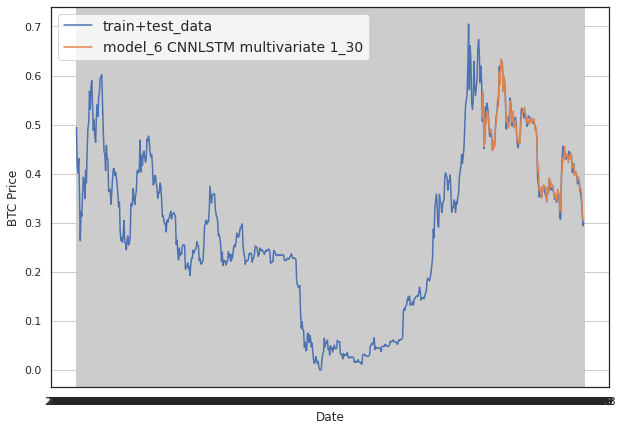

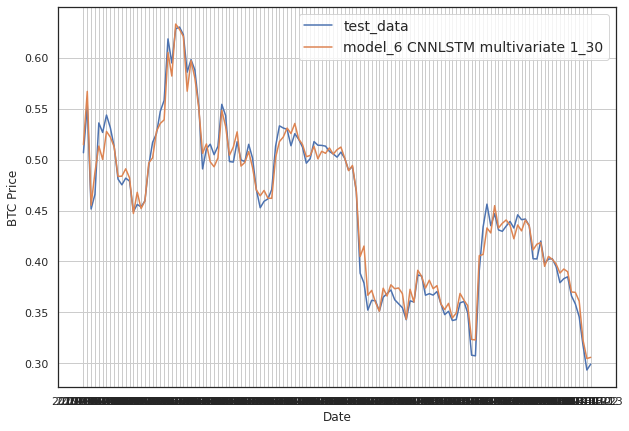

In [70]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X.index, values=y.values, label="train+test_data")
plot_time_series(timesteps=X_test.index, values=model_6_preds, format="-", label="model_6 CNNLSTM multivariate 1_30")

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test.index, values=y_test.values, label="test_data")
plot_time_series(timesteps=X_test.index, values=model_6_preds, format="-", label="model_6 CNNLSTM multivariate 1_30")

### Model_7: Ensemble Model (horizon:1, window:7)

In [71]:
HORIZON=1
WINDOW_SIZE=7

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,btc_inflation_rate,mining_difficulty,hash_rate,trans_count,Price,Vol.,Change %,total_tweets,Google_trends,new_senti,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,
2018-01-01,0.611537,0.0,0.011393,0.335860,0.736042,0.001125,0.411902,0.496942,0.397849,0.679759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.769345,0.0,0.027485,0.648331,0.829572,0.004983,0.781505,0.656769,0.505376,0.692928,0.736042,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.621649,0.0,0.012611,0.821553,0.853822,0.002954,0.577013,0.670663,0.516129,0.687278,0.829572,0.736042,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.737261,0.0,0.024354,0.913000,0.859708,0.003242,0.501750,0.624261,0.473118,0.692738,0.853822,0.829572,0.736042,NaN,NaN,NaN,NaN
2018-01-05,0.474377,0.0,0.000000,0.653859,0.988159,0.005259,0.838390,0.643323,0.462366,0.699413,0.859708,0.853822,0.829572,0.736042,NaN,NaN,NaN
2018-01-06,0.736851,0.0,0.025063,0.704616,1.000000,0.001483,0.534714,0.506453,0.419355,0.688312,0.988159,0.859708,0.853822,0.829572,0.736042,NaN,NaN
2018-01-07,0.673444,0.0,0.018502,0.734053,0.932795,0.001163,0.336931,0.550102,0.397849,0.806413,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042,NaN
2018-01-08,0.715345,0.0,0.022046,0.663125,0.848753,0.005291,0.272462,0.176259,0.473118,0.686246,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042
2018-01-09,0.694073,0.0,0.020519,0.709095,0.806697,0.000668,0.458868,0.689480,0.451613,0.665393,0.848753,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572


In [73]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(548, 548, 137, 137)

In [74]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 16), (None,)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 16), (None,)), types: (tf.float32, tf.float32)>)

In [75]:
def model_ensemble(horizon=HORIZON,train_data=train_dataset,test_data=test_dataset,num_iterations=10,num_epochs=300,loss_funcs=["mae", "mse", "mape"]):
    ensemble_models =[]
    for i in range(num_iterations):
        for j in loss_funcs:
            print(f'Loss function: {j}, Epochs: {num_epochs}, model#: {i}')
            model = Sequential([
                layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",
                                  activation="relu"),
                layers.LSTM(64, return_sequences=True),
                layers.LSTM(64, return_sequences=True),
                layers.Dense(30, activation="relu"),
                layers.Dense(10, activation="relu"),
                layers.Dense(1) 
            ])
            model.compile(loss=j,optimizer=tf.keras.optimizers.Adam(),metrics=["mae", "mse"])
            
            model.fit(train_data,epochs=num_epochs,validation_data=test_data,verbose=0,
                     callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=100,verbose=1)])
            
            ensemble_models.append(model)
            
    return ensemble_models

In [76]:
%%time

ensemble_models = model_ensemble(num_iterations=10,
                                      num_epochs=1500)

Loss function: mae, Epochs: 1500, model#: 0

Epoch 00174: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Loss function: mse, Epochs: 1500, model#: 0

Epoch 00203: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00303: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00403: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00503: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00603: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00703: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00803: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00903: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 01003: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 01103: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 01203: R

2022-04-27 21:54:18.973093: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled



Epoch 00711: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00811: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00911: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 01011: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 01111: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 01211: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 01311: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.

Epoch 01411: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
Loss function: mae, Epochs: 1500, model#: 7

Epoch 00413: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00513: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00613: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00713: ReduceLROnPlateau reducing learning rate to

In [77]:
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data) # make predictions with current ensemble model
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [78]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(30, 137), dtype=float32, numpy=
array([[0.6533941 , 0.60369205, 0.6101677 , ..., 0.3105359 , 0.29069337,
        0.29726398],
       [0.6104471 , 0.60567415, 0.64434433, ..., 0.37941387, 0.36668435,
        0.37520856],
       [0.00342947, 0.00326778, 0.00326671, ..., 0.00145146, 0.00139266,
        0.00147047],
       ...,
       [0.6300543 , 0.6206561 , 0.67249393, ..., 0.3609557 , 0.34625682,
        0.3597287 ],
       [0.6478466 , 0.61439663, 0.6270419 , ..., 0.31287822, 0.29565006,
        0.28958735],
       [0.6071909 , 0.5994035 , 0.5830003 , ..., 0.36763817, 0.35346404,
        0.32108697]], dtype=float32)>

In [79]:
ensemble_preds.numpy().reshape(1,-1).shape

(1, 4110)

In [80]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 0.0059941253,
 'mse': 7.847572e-05,
 'rmse': 0.008858653,
 'mape': 1.2916826,
 'mase': 0.3599534}

## trial senti

In [81]:
HORIZON=1
WINDOW_SIZE=7

In [82]:
ts_df = ts_df[['Price','new_senti']]

scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(ts_df)

normData = pd.DataFrame(scaler.transform(ts_df), index=ts_df.index, columns=ts_df.columns)

tsdf_w = normData
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    tsdf_w[f"Price+{i+1}"] = tsdf_w["Price"].shift(periods=i+1)
tsdf_w.head(10)

,Price,new_senti,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2018-01-01,0.736042,0.679759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.829572,0.692928,0.736042,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.853822,0.687278,0.829572,0.736042,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.859708,0.692738,0.853822,0.829572,0.736042,NaN,NaN,NaN,NaN
2018-01-05,0.988159,0.699413,0.859708,0.853822,0.829572,0.736042,NaN,NaN,NaN
2018-01-06,1.000000,0.688312,0.988159,0.859708,0.853822,0.829572,0.736042,NaN,NaN
2018-01-07,0.932795,0.806413,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042,NaN
2018-01-08,0.848753,0.686246,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572,0.736042
2018-01-09,0.806697,0.665393,0.848753,0.932795,1.000000,0.988159,0.859708,0.853822,0.829572


In [83]:
X = tsdf_w.dropna().drop("Price", axis=1).astype(np.float32) 
y = tsdf_w.dropna()["Price"].astype(np.float32)


split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(548, 548, 137, 137)

In [84]:
X_train.shape

(548, 8)

In [85]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(8))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) 
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)
model_ = tf.keras.Model(inputs=inputs, outputs=output, name="model__LSTM")

# Compile model
model_.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [86]:
history = model_.fit(X_train, y_train,epochs=300,batch_size=128,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name=model_.name)],verbose=0)

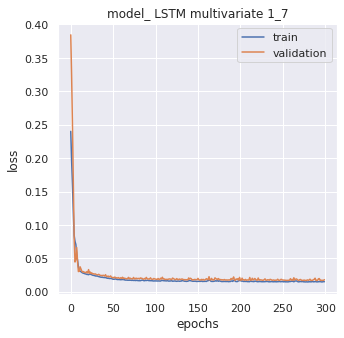

In [87]:
sns.set(rc={"figure.figsize":(5, 5)})
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_ LSTM multivariate 1_7')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [88]:
model_ = tf.keras.models.load_model("./model_experiments/model__LSTM")
model_.evaluate(X_test, y_test)
model__preds = make_preds(model_, X_test)
model__results = evaluate_preds(y_true=tf.squeeze(y_test), 
                                 y_pred=model__preds)
model__results

5/5 [==============================] - 0s 2ms/step - loss: 0.0169


{'mae': 0.016926447,
 'mse': 0.00062411785,
 'rmse': 0.02498235,
 'mape': 3.718853,
 'mase': 1.0164505}